In [4]:
import pandas
import matplotlib.pyplot as plt
import numpy
import tqdm
import os
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import keras

In [5]:
from google.colab import drive
drive.mount('drive/')

Mounted at drive/


In [6]:
data_path = "drive/MyDrive/projet_doctolib"
os.chdir(data_path)

In [7]:
def read_dataset(mit_bih_csv_path):
	df = pandas.read_csv(mit_bih_csv_path)
	df.iloc[:, 187] = df.iloc[:, 187].astype('int64')
	return df.sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
def read_arduino_ecg_data(arduino_ecg_csv_path):
	ecg = pandas.read_csv(arduino_ecg_csv_path)['ECG Value'].values
	ecg = (ecg - numpy.mean(ecg)) / numpy.std(ecg)
	one_beat = numpy.concatenate((ecg[180: 270], numpy.zeros(97)))
	return one_beat

In [9]:
def show_labels_distribution(mit_bih_df):
	# Afficher la distribution des labels dans la colonne 187
	distribution = mit_bih_df.iloc[:, 187].value_counts()


	plt.figure(figsize=(15, 6))
	wedges, texts, autotexts = plt.pie(distribution, autopct='%1.1f%%', startangle=90, labels=None)
	plt.title("Distribution des labels d'arythmie")
	plt.ylabel('')  # Pour ne pas afficher "187" comme étiquette de l'axe y
	plt.legend(
	    wedges,
	    [label_mapping[idx] for idx in distribution.index],
	    title="Categories",
	    loc="center left",
	    bbox_to_anchor=(1, 0, 0.5, 1)  # Positionnement de la légende
	)
	plt.show()
	# Afficher le résultat
	print(distribution)
	return None


In [10]:
def generate_x_y_values(mit_bih_df):
	ecgs, arythmies_labels = [], []
	for _, row in tqdm.tqdm(mit_bih_df.iterrows(), total=len(mit_bih_df)):
		ecgs.append(row.iloc[0 : 187].values)
		arythmies_labels.append(int(row.iloc[187]))

	return numpy.array(ecgs), numpy.array(arythmies_labels)


In [11]:
mit_bih_csv_path="mitbih_train.csv"
mit_bih_df = read_dataset(mit_bih_csv_path)
label_mapping = {0 : "Normal",
				1 : "Artial Premature",
				2 : "Premature ventricular contraction",
				3 : "Fusion of ventricular and normal",
				4 : "Fusion of paced and normal",
				}

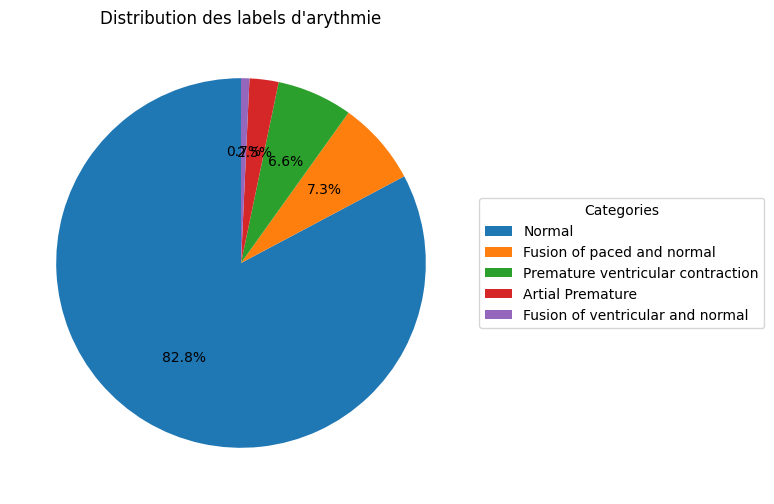

0.000000000000000000e+00.88
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


In [12]:
show_labels_distribution(mit_bih_df)

In [13]:
ecgs, arythmies_labels = generate_x_y_values(mit_bih_df)

100%|██████████| 87553/87553 [00:06<00:00, 13155.43it/s]


In [14]:
print(ecgs[0])
print(arythmies_labels[0])

[0.93877554 0.89540815 0.72193879 0.29081634 0.125      0.15051021
 0.1377551  0.05867347 0.04591837 0.04081633 0.06122449 0.06122449
 0.05102041 0.04846939 0.06887755 0.05867347 0.07397959 0.06632653
 0.07653061 0.06632653 0.07142857 0.06377551 0.10969388 0.09183674
 0.10714286 0.09948979 0.125      0.12244898 0.11989796 0.1122449
 0.14795919 0.1377551  0.13520408 0.12244898 0.14285715 0.13520408
 0.13520408 0.12244898 0.14030612 0.11989796 0.13265306 0.125
 0.13010204 0.11734694 0.11734694 0.08928572 0.10969388 0.08928572
 0.08418367 0.06377551 0.0867347  0.08418367 0.0867347  0.08418367
 0.10969388 0.09948979 0.10969388 0.11479592 0.14030612 0.14540817
 0.16071428 0.18367347 0.22448979 0.23469388 0.21683674 0.21683674
 0.20663266 0.21428572 0.16581632 0.14030612 0.12244898 0.13265306
 0.10459184 0.10459184 0.10969388 0.10969388 0.04846939 0.
 0.10459184 0.40051019 0.68112242 0.92091835 1.         0.90561223
 0.50765306 0.17346939 0.18622449 0.2117347  0.10969388 0.07908163
 0.073979

In [15]:
scaler = StandardScaler() # ça passe la moyenne à 0 et l'écart type 1
normalised_ecgs = scaler.fit_transform(ecgs)
normalised_ecgs = normalised_ecgs.reshape(normalised_ecgs.shape[0], normalised_ecgs.shape[1], 1)

In [16]:
model = Sequential(
    [
        LSTM(100, input_shape=(187, 1)),#Encodeur
        Dense(5, activation="softmax")#Classifieur (nb_neurones, fonction d'activation : softmax)
        ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])#sparse

In [20]:
history = model.fit(normalised_ecgs, arythmies_labels, validation_split=0.15, epochs=10000, batch_size=32, verbose=2, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/10000
2326/2326 - 25s - 11ms/step - accuracy: 0.9481 - loss: 0.1890 - val_accuracy: 0.9430 - val_loss: 0.2081
Epoch 2/10000
2326/2326 - 36s - 15ms/step - accuracy: 0.9477 - loss: 0.1919 - val_accuracy: 0.9369 - val_loss: 0.2273
Epoch 3/10000
2326/2326 - 22s - 9ms/step - accuracy: 0.9460 - loss: 0.2020 - val_accuracy: 0.9500 - val_loss: 0.1881
Epoch 4/10000
2326/2326 - 40s - 17ms/step - accuracy: 0.9496 - loss: 0.1838 - val_accuracy: 0.9521 - val_loss: 0.1837
Epoch 5/10000
2326/2326 - 20s - 9ms/step - accuracy: 0.9477 - loss: 0.1899 - val_accuracy: 0.9311 - val_loss: 0.2348
Epoch 6/10000
2326/2326 - 21s - 9ms/step - accuracy: 0.9509 - loss: 0.1791 - val_accuracy: 0.9520 - val_loss: 0.1786
Epoch 7/10000
2326/2326 - 20s - 9ms/step - accuracy: 0.9498 - loss: 0.1829 - val_accuracy: 0.9524 - val_loss: 0.1788
Epoch 8/10000
2326/2326 - 20s - 9ms/step - accuracy: 0.9524 - loss: 0.1737 - val_accuracy: 0.9510 - val_loss: 0.1849
Epoch 9/10000
2326/2326 - 20s - 9ms/step - accuracy: 0.9466 -

In [21]:
normalised_ecgs.shape

(87553, 187, 1)

In [22]:
arythmies_labels.shape

(87553,)

In [25]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcul des class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(arythmies_labels),
    y=arythmies_labels
)

# Création du dictionnaire de poids
class_weight_dict = dict(zip(np.unique(arythmies_labels), class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 0.2416255002069822, 1: 7.877013045434098, 2: 3.025328265376641, 3: 27.317628705148206, 4: 2.7228424817291246}


In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow import keras

# 1. Exponential Decay et Optimizer
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.95

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# 2. Définition des métriques
metrics = [
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
]

# 3. Exemple de modèle
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(20,)),  # Remplace 20 par ton nombre de features
    keras.layers.Dense(10, activation='softmax')  # Exemple pour 10 classes
])

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=metrics
)

# Supposons que X_train, y_train, X_val, y_val sont définis
# model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# 4. Fonction d'évaluation
label_mapping = {i: f'Class {i}' for i in range(10)}  # Exemple : 10 classes

def evaluate_detailed(model, X_val, y_val):
    # Prédictions
    y_pred = np.argmax(model.predict(X_val), axis=1)

    # Rapport de classification
    print(classification_report(y_val, y_pred, target_names=label_mapping.values()))

    # Matrice de confusion
    plt.figure(figsize=(10, 8))
    conf_matrix = confusion_matrix(y_val, y_pred)
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        xticklabels=label_mapping.values(),
        yticklabels=label_mapping.values(),
        cmap="Blues"
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Appelle cette fonction avec ton modèle entraîné
# evaluate_detailed(model, X_val, y_val)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
from keras.callbacks import LearningRateScheduler

# Définir une fonction de décroissance du learning rate
def lr_decay(epoch, lr):
    decay_rate = 0.1
    decay_step = 10  # Réduire le learning rate tous les 10 epochs
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

# Ajouter le callback lors de l'entraînement
lr_scheduler = LearningRateScheduler(lr_decay)
